🛠 제거된 피처들 (상관관계 0.9 이상): ['concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'perimeter_se', 'area_se', 'texture_mean']

✅ 최종 선택된 피처들: ['concave points_worst', 'perimeter_worst', 'concavity_worst', 'compactness_mean', 'compactness_worst', 'radius_se', 'texture_worst', 'smoothness_worst', 'symmetry_worst', 'concave points_se']

✅ 최적의 C 값: 1

✅ 최적화된 로지스틱 회귀 모델 정확도: 0.9825


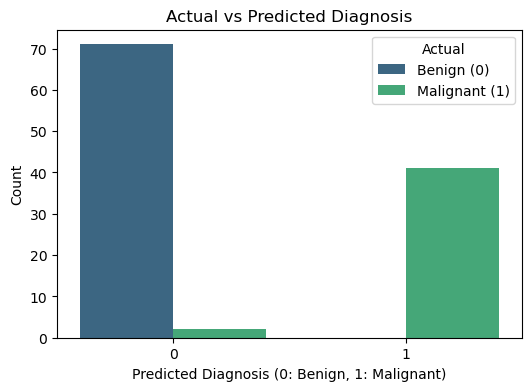

In [1]:
###  GPT가 작성한 최적화된 로지스틱 회귀 전체 코드
# import warnings
# warnings.filterwarnings("ignore") # 불필요한 경고 무시하는 기능

import pandas as pd # 데이터 읽기
import seaborn as sns # 이쁘게 출력, 기본출력이 있어야만 가능
import matplotlib.pyplot as plt # 기본출력
from sklearn.model_selection import train_test_split, GridSearchCV #
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 불러오기
file_path = "data.csv"  # 파일 경로 설정
df = pd.read_csv(file_path)

# 불필요한 열 제거 (id, Unnamed: 32)
df = df.drop(columns=['id', 'Unnamed: 32'])

# diagnosis를 0과 1로 변환 (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# diagnosis와의 상관관계 분석 후 상위 20개 피처 선택
correlation = df.corr()['diagnosis'].abs().sort_values(ascending=False)
top_features = correlation.index[1:21]  # diagnosis 제외하고 상위 20개 선택



import numpy as np # corr 0.9이상 자동 제거 함수 만들려고
# 상관관계 높은 피처 자동 제거 (0.9 이상)
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"🛠 제거된 피처들 (상관관계 {threshold} 이상): {to_drop}")
    return df.drop(columns=to_drop)

df_reduced = remove_highly_correlated_features(df[top_features])

# 최종 선택된 피처
selected_features = df_reduced.columns.tolist()
print(f"\n✅ 최종 선택된 피처들: {selected_features}")

# 데이터셋 생성
X = df[selected_features]
y = df['diagnosis']

# 데이터 분할 (훈련 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화 (StandardScaler 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 최적의 C 값 찾기 (GridSearchCV)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_c = grid_search.best_params_['C']
print(f"\n✅ 최적의 C 값: {best_c}")

# 최적의 C 값을 사용하여 로지스틱 회귀 모델 학습
model = LogisticRegression(C=best_c, max_iter=10000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

# 예측 및 정확도 평가
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ 최적화된 로지스틱 회귀 모델 정확도: {accuracy:.4f}")

# 예측 결과 DataFrame 생성
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# countplot 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='Predicted', hue='Actual', data=df_results, palette="viridis")
plt.title('Actual vs Predicted Diagnosis')
plt.xlabel('Predicted Diagnosis (0: Benign, 1: Malignant)')
plt.ylabel('Count')
plt.legend(title="Actual", labels=["Benign (0)", "Malignant (1)"])
plt.show()
